# Convolutional Neural Network GoogLeNet

In [1]:
import os
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ["CUDA_VISIBLE_DEVICES"]="1"

base_dir = 'uta_dataset/vgg16images'
drowsy_dir = os.path.join(base_dir, 'DrowsyVGG')
alert_dir = os.path.join(base_dir, 'AlertVGG')

# Creating a function to split data.
def create_splits(data_dir, output_dir, split_ratio=(0.7, 0.10, 0.20)):
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    
    for category in ['DrowsyVGG', 'AlertVGG']:
        category_dir = os.path.join(data_dir, category)
        images = os.listdir(category_dir)
        train_imgs, test_imgs = train_test_split(images, test_size=split_ratio[1] + split_ratio[2], random_state=42)
        val_imgs, test_imgs = train_test_split(test_imgs, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]), random_state=42)
        
        for dset, imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
            output_dset_dir = os.path.join(output_dir, dset, category)
            os.makedirs(output_dset_dir, exist_ok=True)
            for img in imgs:
                shutil.copy(os.path.join(category_dir, img), output_dset_dir)

# Splitting the dataset.
create_splits(base_dir, 'splitted_dataset')

# Splitting the data.
train_dir = os.path.join('splitted_dataset', 'train')
val_dir = os.path.join('splitted_dataset', 'val')
test_dir = os.path.join('splitted_dataset', 'test')

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='binary',
    shuffle=False)


2024-02-28 13:43:11.230185: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Found 7092 images belonging to 2 classes.
Found 1013 images belonging to 2 classes.
Found 2029 images belonging to 2 classes.


In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.layers import concatenate

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 

    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer



def GoogLeNet():
     
    input_layer = Input(shape = (224, 224, 3))

    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(1, activation = 'sigmoid')(X1)


    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(1, activation = 'sigmoid')(X2)


    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    X = GlobalAveragePooling2D(name = 'GAPL')(X)
 
    X = Dropout(0.4)(X)
 
    X = Dense(1, activation = 'sigmoid')(X)

    model = Model(input_layer, X, name = 'GoogLeNet')

    return model

In [3]:
model = GoogLeNet()
model.compile(optimizer=optimizers.Adamax(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks.
callbacks = [
    ModelCheckpoint('GoogLeNet_drowsiness_detection.h5', save_best_only=True, monitor='val_loss')
]

# Train the model.
history = model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50,  
    callbacks=callbacks
)


2024-02-28 13:43:13.673503: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-28 13:43:13.674504: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-28 13:43:13.694176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:5e:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2024-02-28 13:43:13.694211: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-28 13:43:13.697332: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 13:43:13.697400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-0

Epoch 1/50


2024-02-28 13:43:17.339040: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-28 13:43:18.100715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2024-02-28 13:43:18.107925: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2024-02-28 13:43:20.862279: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


100/100 [==============================] - 11s 49ms/step - loss: 0.6979 - accuracy: 0.4957 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 4s 41ms/step - loss: 0.6920 - accuracy: 0.5313 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 3/50
100/100 [==============================] - 5s 49ms/step - loss: 0.6932 - accuracy: 0.4906 - val_loss: 0.6933 - val_accuracy: 0.4990
Epoch 4/50
100/100 [==============================] - 4s 40ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 5/50
100/100 [==============================] - 4s 40ms/step - loss: 0.6928 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4980
Epoch 6/50
100/100 [==============================] - 4s 41ms/step - loss: 0.6933 - accuracy: 0.4986 - val_loss: 0.6931 - val_accuracy: 0.4980
Epoch 7/50
100/100 [==============================] - 4s 39ms/step - loss: 0.6937 - accuracy: 0.4819 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 8/5

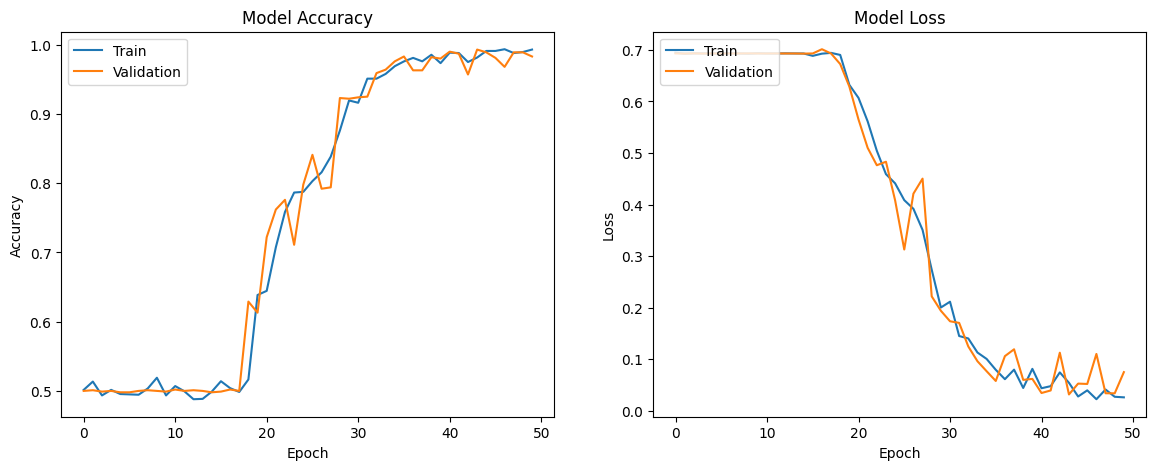

In [4]:
# Plot training & validation accuracy values.
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


50/50 [==============================] - 1s 25ms/step - loss: 0.1334 - accuracy: 0.9660
Test accuracy: 0.9660000205039978
F1 Score: 0.9810218978102189


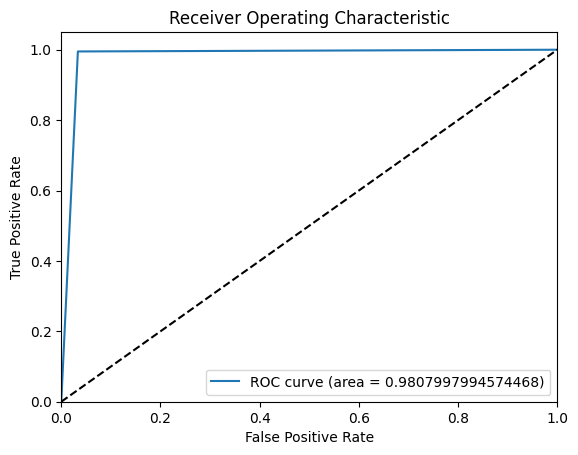

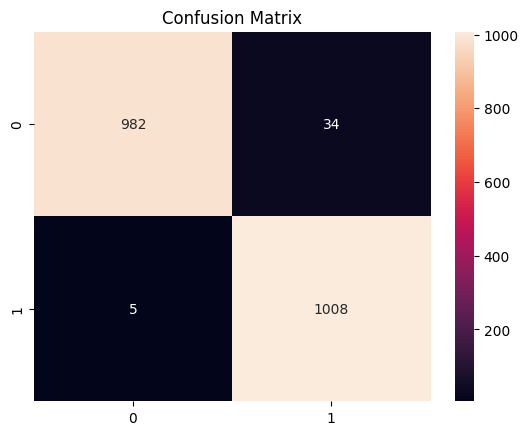

Sensitivity: 0.9665354330708661
Specificity: 0.9950641658440277


In [5]:
# Evaluate the model on the test set.
test_loss, test_acc = model.evaluate(test_generator, steps=50)  # Adjust steps accordingly
print(f"Test accuracy: {test_acc}")

# Predictions for ROC and F1.
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5).astype(int)
y_true = test_generator.classes

f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1}")

# ROC Curve.
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix for Sensitivity and Specificity.
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.show()

# Sensitivity and Specificity.
sensitivity = cm[0,0] / (cm[0,0] + cm[0,1])
specificity = cm[1,1] / (cm[1,0] + cm[1,1])
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")


In [7]:
# Carbon Tracker.
import gc
from carbontracker.tracker import CarbonTracker

tracker = CarbonTracker(epochs=50)
tracker.epoch_start()

history_tracker= model.fit(
    train_generator,
    steps_per_epoch=100,  
    epochs=1,
    validation_data=validation_generator,
    validation_steps=50, 
)
tracker.epoch_end()
tracker.stop()
gc.collect()

CarbonTracker: The following components were found: GPU with device(s) NVIDIA RTX A6000. CPU with device(s) cpu:1, cpu:0.
CarbonTracker: The following components were found: GPU with device(s) NVIDIA RTX A6000. CPU with device(s) cpu:1, cpu:0.
100/100 [==============================] - 4s 41ms/step - loss: 0.0230 - accuracy: 0.9950 - val_loss: 0.0781 - val_accuracy: 0.9810
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:04
	Energy:	0.000259 kWh
	CO2eq:	0.069712 g
	This is equivalent to:
	0.000579 km travelled by car
CarbonTracker: 
Actual consumption for 1 epoch(s):
	Time:	0:00:04
	Energy:	0.000259 kWh
	CO2eq:	0.069712 g
	This is equivalent to:
	0.000579 km travelled by car
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:03:28
	Energy:	0.012958 kWh
	CO2eq:	nan g
CarbonTracker: 
Predicted consumption for 50 epoch(s):
	Time:	0:03:28
	Energy:	0.012958 kWh
	CO2eq:	nan g
CarbonTracker: Finished monitoring.
CarbonTracker: Finished monitoring.


/home/dll/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dll/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


14805